# Chronos Test

In this example, we will test Chronos on canonical geoscientific data sets chosen to be representative of geoscience/geophysics:
1. earthquake catalogs from SoCal
2. earthquake ground motion waveforms
3. near surface properties (seismic velocities, temperature, soil moisture)
4. ice velocity from greenland
5. GPS positions along a plate boundary that captures seasons and tectonic loading

The data has been prepared as CSV files with times series.
The forescasts are added to the CSV files under key attributes "Chronos-zero-shot".

Limitations by [Chronos](https://arxiv.org/pdf/2403.07815). Chronos uses large language models at its core for forecasting time series. The time series is "tokenized" to convert from an array of floats into contect tokens.


By Marine Denolle (mdenolle@uw.edu)


In [6]:
import matplotlib.pyplot as plt
import torch
from chronos import ChronosPipeline
import pandas as pd

In [2]:
prediction_length = 64

In [ ]:
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-base",
    device_map="cpu",  # use "cpu" for CPU inference and "mps" for Apple Silicon
    torch_dtype=torch.bfloat16,
)

## Load data

1. Earthquake catalogs

In [9]:
# first we load data/data_qtm_catalog.csv
df = pd.read_csv("../data/data_qtm_catalog.csv")
df.head()

,datetime,count
0,2008-01-01,120
1,2008-01-02,89
2,2008-01-03,146
3,2008-01-04,166
4,2008-01-05,94


In [10]:
# we rename the column "count" to "target"
df = df.rename(columns={"count": "target"})

In [12]:
# context must be either a 1D tensor, a list of 1D tensors,
# or a left-padded 2D tensor with batch as the first dimension
# forecast shape: [num_series, num_samples, prediction_length]
forecast = pipeline.predict(
    context=torch.tensor(df["target"].values[:-prediction_length], dtype=torch.float32),
    prediction_length=prediction_length,
    num_samples=20,
)

In [14]:
import matplotlib.pyplot as plt  # requires: pip install matplotlib
import numpy as np

forecast_index = range(len(df), len(df) + prediction_length)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)


# Assuming event_counts_df is your DataFrame with a datetime index
# Get the last date from the event_counts_df index
last_date = df.index[-prediction_length]


# Create a new date range for the forecast
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=prediction_length, freq='D')
print(len(forecast_dates))
print(len(median))
plt.figure(figsize=(8, 4))
plt.plot(df["target"], color="royalblue", label="evt counts")
plt.plot(forecast_dates, median, color="tomato", label="median forecast")
plt.fill_between(forecast_dates, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.ylim([0,100])
plt.show()

TypeError: unsupported operand type(s) for +: 'int' and 'Timedelta'

In [15]:
import pandas as pd

# Assuming event_counts is a dictionary with dates as keys and counts as values
# Convert the dictionary to a DataFrame
event_counts_df = pd.DataFrame(list(event_counts.items()), columns=['date', 'count'])

# Convert the date column to datetime
event_counts_df['date'] = pd.to_datetime(event_counts_df['date'])

# Normalize the dates to the first day of the month
event_counts_df['month'] = event_counts_df['date'].dt.to_period('M')

# Aggregate the counts by month
monthly_event_counts = event_counts_df.groupby('month')['count'].sum().reset_index()

# Convert the 'month' column back to datetime for easier plotting
monthly_event_counts['month'] = monthly_event_counts['month'].dt.to_timestamp()

print(monthly_event_counts)

        month  count
0  2016-01-01     22
1  2016-02-01     30
2  2016-03-01     20
3  2016-04-01     18
4  2016-05-01     16
5  2016-06-01     32
6  2016-07-01     17
7  2016-08-01     24
8  2016-09-01     39
9  2016-10-01     25
10 2016-11-01     19
11 2016-12-01     44
12 2017-01-01     22
13 2017-02-01     12
14 2017-03-01     22
15 2017-04-01     23
16 2017-05-01     23
17 2017-06-01     24
18 2017-07-01     17
19 2017-08-01     15
20 2017-09-01     17
21 2017-10-01     16
22 2017-11-01     19
23 2017-12-01     23
24 2018-01-01     17
25 2018-02-01     20
26 2018-03-01     15
27 2018-04-01     21
28 2018-05-01     25
29 2018-06-01     11
30 2018-07-01     18
31 2018-08-01     18
32 2018-09-01     18
33 2018-10-01     23
34 2018-11-01     30
35 2018-12-01     16
36 2019-01-01     24
37 2019-02-01     22
38 2019-03-01     12
39 2019-04-01     31
40 2019-05-01     18
41 2019-06-01     33
42 2019-07-01   1738
43 2019-08-01     95
44 2019-09-01     44
45 2019-10-01     37
46 2019-11-01

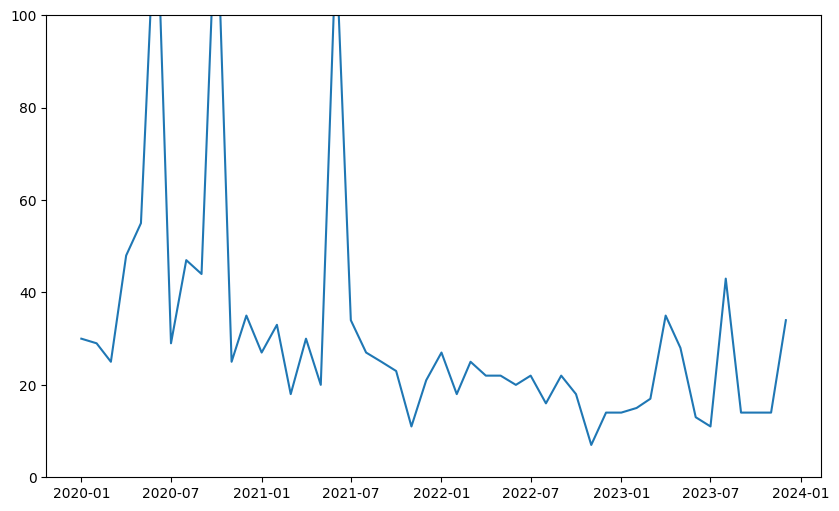

In [ ]:
# plot the number of events per month
plt.figure(figsize=(10, 6))
plt.plot(monthly_event_counts['month'], monthly_event_counts['count'])
plt.ylim([0, 100])
# plt.plot( event_counts_df['count'])
plt.show()

In [16]:
prediction_length = 12
# context must be either a 1D tensor, a list of 1D tensors,
# or a left-padded 2D tensor with batch as the first dimension
# forecast shape: [num_series, num_samples, prediction_length]
forecast = pipeline.predict(
    context=torch.tensor(monthly_event_counts["count"].values[:-prediction_length], dtype=torch.float32),
    prediction_length=prediction_length,
    num_samples=20,
)

In [17]:
import matplotlib.pyplot as plt  # requires: pip install matplotlib
import numpy as np

forecast_index = range(len(monthly_event_counts), len(monthly_event_counts) + prediction_length)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)


# Assuming event_counts_df is your DataFrame with a datetime index
# Get the last date from the event_counts_df index
# set month as the index of the dataframe
monthly_event_counts = monthly_event_counts.set_index('month')
# and remove month as the index name
# monthly_event_counts.index.name = None
last_date = monthly_event_counts.index[-prediction_length]


# Create a new date range for the forecast
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=prediction_length, freq='M')


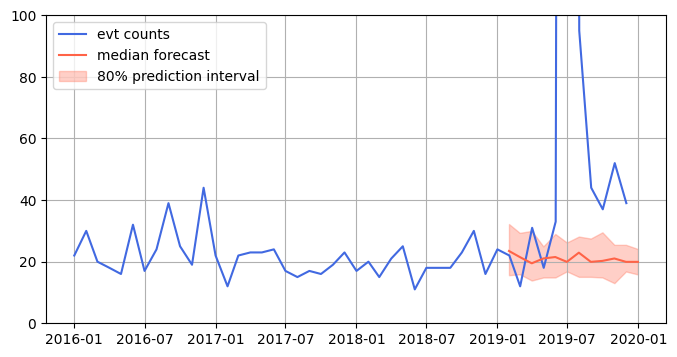

In [18]:

plt.figure(figsize=(8, 4))
plt.plot(monthly_event_counts["count"], color="royalblue", label="evt counts")
plt.plot(forecast_dates, median, color="tomato", label="median forecast")
plt.fill_between(forecast_dates, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.ylim([0,100])
plt.show()